In [26]:
import os
# import pandas as pd 
import polars as pl
# import scanpy as sc
import numpy as np
import typing as tp
import re
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import umap as umap
# import pacmap as umap
# import hdbscan as hdb

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

'/share/data/analyses/christa/colopaint3D/spher_colo52_v1'

In [40]:
print(os.getcwd())
os.chdir('/scratch2-shared/david/colopaint3D/python/data/')
print(os.getcwd())

/
/scratch2-shared/david/colopaint3D/python/data


In [18]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [19]:
# fig.savefig(
#         "Detected_Cells_Spheroid_{}_{}_{}.{}".format(cell_line,well,barcode,figformat), dpi=dpi, bbox_inches="tight"
#         )

# plt.show()

In [46]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./share/data/analyses/christa/colopaint3D/spher_colo52_v1'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
feat_pp = '1_FeaturesImages_meanstd_PerPlate'
feat_fe = '1_FeaturesImages_meanstd'
# feat_agg = '/share/data/analyses/christa/colopaint3D/spher_colo52_v1'

# feat_pp = './old_features3/1_FeaturesImages_meanstd_PerPlate'
# feat_fe = './old_features3/1_FeaturesImages_meanstd'


In [28]:

filenames = ['SingleSlice/HCT116_Slices_medianAgg', 'SingleSlice/HT29_Slices_medianAgg']

statmet = 'SingleSlice'

statmets = ['SingleCell', 'Aggregates']

dropcols = ['Nuclei_Location_Center_X',
            'Nuclei_Location_Center_Y',
            'Location',
            'ImageNumber_',
            'Parent',
            'Children',
            '_ObjectNumber',
            '_Object_Number',
            '_Y',
            '_X' 
            ]


cons = ['pos_con', 'neg_con']
nodmso = ['trt']
wdmso = ['pos_con']
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]
str_columns = [pl.col(pl.String)]
str_columns = [pl.col(pl.Int64),pl.col(pl.Int32)]
feat_sc = f'{feat_pp}/{statmet}'
ignore_labels = ['water','water+','flup','dmso']
frac_wells = 0.15


In [22]:
# cmap = {'MAPK': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
#         'Cell Cycle': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
#         'DNA Damage': (1.0, 0.4980392156862745, 0.054901960784313725),
#         'PI3K/Akt/mTOR': (1.0, 0.7333333333333333, 0.47058823529411764),
#         'Epigenetics': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#         'Stem Cells & Wnt': (0.596078431372549,
#         0.8745098039215686,
#         0.5411764705882353),
#         'Angiogenesis': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
#         'Protein Tyrosine Kinase': (1.0, 0.596078431372549, 0.5882352941176471),
#         'Apoptosis': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
#         'JAK/STAT': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
#         'Cytoskeletal Signaling': (0.5490196078431373,
#         0.33725490196078434,
#         0.29411764705882354),
#         'TGF-beta/Smad': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
#         'Others': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
#         'Proteases': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)}

In [29]:
feat_pp

'./scratch2-shared/david/colopaint3D/python/data/1_FeaturesImages_meanstd_PerPlate'

In [61]:
def readData(filename, feat_dir, statmet='SingleCell', filetype='parquet'):
    if filetype=='parquet':
        df = pl.read_parquet(f'{feat_dir}/{filename}.parquet')
    elif filetype=='csv':
        df = pl.read_csv(f'{feat_dir}/{filename}.csv')
    
    #Ensuring no NaN labels exist for Pathways
    df = replace_nan_labels(df)

    ##This here is important!!!!!!
    # df=df.select([c for c in df.columns if not is_meta_column(c)])
    # dataNpy = df.to_numpy(df.select(float_columns))
    ##
    df = df.filter(~pl.col('Metadata_cmpd_pathway').is_in(ignore_labels))
    df = df.filter(~pl.col('Metadata_cmpd_pert_type').is_in(cons))
    onehot_list = df.select(['Metadata_cmpd_pathway'])['Metadata_cmpd_pathway'].unique().to_list()
    onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
    df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_onehot'))
    

    df = df.with_columns(
    pl.when(
        pl.col("Metadata_onehot").map_elements(lambda s: np.random.rand() < frac_wells)
    )
    .then(-1)
    .otherwise(pl.col("Metadata_onehot"))
    .alias("Metadata_semi")
    )

    return df

def replace_nan_labels(df):
    df = df.with_columns(
    pl.when(pl.col('Metadata_cmpd_pathway').is_null())
      .then(pl.col('Metadata_cmpd_cmpdname'))
      .otherwise(pl.col('Metadata_cmpd_pathway'))
      .alias('Metadata_cmpd_pathway')
    )
    return df

def modify_half_of_each_class(group):
    # Sample 50% of the rows from the group
    sample_size = int(group.shape[0] * 0.5)
    sampled_indices = np.random.choice(group.shape[0], size=sample_size, replace=False)
    
    # Set those rows to -1
    group = group.with_columns(
        pl.when(pl.Series(np.isin(np.arange(group.shape[0]), sampled_indices)))
        .then(-1)
        .otherwise(pl.col("Metadata_onehot"))
        .alias("Metadata_semi")
    )
    return group


# this is code from Dan
def is_meta_column(
    c:str,
    allowlist:tp.List[str]=["Metadata_AcqID","Metadata_Site"],
    denylist:tp.List[str]=["Metadata_Well","Metadata_barcode"],
)->bool:
    """
        allowlist:
            the function will return False for these, no matter if they are metadata or not
        denylist:
            the function will return True for these, no matter if they are metadata or not
    """
    if c in allowlist:
        return False
    if c in denylist:
        return True
    for ex in '''
        Metadata
        Plate
        Well
    '''.split():
        if re.search(ex, c):
            return True
    return False


def oneHot(row, mapping):
    return mapping.get(row, -1)

def makePCA(df, cmap,name='', n_components=2):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    pca_model = PCA(n_components=n_components)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    df = df.with_columns([
    pl.Series('pc1', pcaOut[:, 0]),  
    pl.Series('pc2', pcaOut[:, 1])   
    ])

    hue = df['Metadata_Site'].to_list()
    # cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_pathway'].unique().to_list()))
    # cmap = cmap
    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['pc1'].to_list(),
                    y=df['pc2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'PCA {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()
    return ax, df

def makeUMAP(df, cmap, name='', statmet='SingleCell', nn = 200, sup_mode=True, n_components=100, min_dist=0.1, spread= 1, n_epochs=None, metric='cosine', use_pca=True, random_state=42):
    if sup_mode=='traintest':
        dfN = df.filter(pl.col('Metadata_semi')!=-1)
        dfY = df.filter(pl.col('Metadata_semi')==-1)
        dataN=dfN.select([c for c in dfN.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
        dataY=dfY.select([c for c in dfN.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    else:
        dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()

    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        , n_jobs=-1
                        , random_state=random_state
                        )
    # umap_model = umap.PaCMAP(n_components=2,MN_ratio=0.5, FP_ratio=2.0, distance='angular')
    if sup_mode=='traintest':
        umapOut = umap_model.fit_transform(dataN, y=dfN['Metadata_onehot'].to_list())
        umapPred = umap_model.transform(dataY)
        dfN = dfN.with_columns([
        pl.Series('umap1', umapOut[:, 0]),  
        pl.Series('umap2', umapOut[:, 1])   
        ])
        dfY = dfY.with_columns([
        pl.Series('umap1', umapPred[:, 0]),  
        pl.Series('umap2', umapPred[:, 1])   
        ])
        df = pl.concat([dfN, dfY])
        isSup = 'Semi-Supervised train-test'
    else:
        if use_pca:
            pca_model = PCA(n_components=n_components)
            pca_model = pca_model.fit(dataN)
            dataN = pca_model.transform(dataN)
        if sup_mode=='supervised':
            umapOut = umap_model.fit_transform(dataN, y=df['Metadata_onehot'].to_list())
            isSup = 'Supervised'
        elif sup_mode=='semi':
            umapOut = umap_model.fit_transform(dataN, y=df['Metadata_semi'].to_list())
            isSup = 'Semi-Supervised with partial labeling'
        else:
            umapOut = umap_model.fit_transform(dataN)
            isSup = 'Unsupervised'
        df = df.with_columns([
        pl.Series('umap1', umapOut[:, 0]),  
        pl.Series('umap2', umapOut[:, 1])   
        ])

    
    # cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot()
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    if sup_mode == 'supervised' or sup_mode == 'unsupervised':
        hue = df['Metadata_Site'].to_list()
        sns.scatterplot(x=df['umap1'].to_list(),
                        y=df['umap2'].to_list(),
                        palette=cmap, hue=hue,
                        marker='.',
                        ).set(title=f'umap {df.select(pl.col("Metadata_cell_line")).unique().item(0, 0)} {sup_mode}'
                    )
    else:
        df_s1 = df.filter(pl.col('Metadata_semi')!=-1)
        df_s1 = df_s1.select(pl.col(['umap1', 'umap2','Metadata_cmpd_pathway', 'Metadata_onehot', 'Metadata_semi']))
        hue = df_s1['Metadata_Site'].to_list()
        sns.scatterplot(x=df_s1['umap1'].to_list(),
                        y=df_s1['umap2'].to_list(),
                        palette=cmap, hue=hue,
                        marker='.',
                        ax=ax
                        ).set(title=f'umap {df.select(pl.col("Metadata_cell_line")).unique().item(0, 0)} {sup_mode}'
                    )
        df_s2 = df.filter(pl.col('Metadata_semi')==-1)
        df_s2 = df_s2.select(pl.col(['umap1', 'umap2','Metadata_cmpd_pathway', 'Metadata_onehot', 'Metadata_semi']))
        hue = df_s2['Metadata_Site'].to_list()
        sns.scatterplot(x=df_s2['umap1'].to_list(),
                        y=df_s2['umap2'].to_list(),
                        palette=cmap, hue=hue,
                        marker='o',
                        ax=ax,
                        s=30, alpha=0.7
                        ).set(title=f'umap {df.select(pl.col("Metadata_cell_line")).unique().item(0, 0)} {sup_mode}'
                    )

    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}'):
    #     os.makedirs(f'{OutputDir}/{statmet}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return ax, df

def filter_and_clean(df):
    df_3d = scrub(df.filter(pl.col('Metadata_data_type')=='aggregates'))
    # print(df_3d.head(), df.head())
    df_2d = scrub(df.filter(pl.col('Metadata_data_type')=='2D'))
    df_mip = scrub(df.filter(pl.col('Metadata_data_type')=='MIP'))
    return df_3d, df_2d, df_mip

def scrub(df):
    float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]
    df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

    df_bool = df_floats.select(pl.all().is_nan().all())
    cols_to_drop = [col for col, is_all_nan in zip(df_floats.columns, df_bool.row(0)) if is_all_nan] 
    df = df.drop(cols_to_drop)

    #Checking if NaNs remains after column scrubbing
    df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)
    has_nan = df_floats.select(pl.all().is_nan().any()).row(0)[0]
    print(f'Has NaNs after column scrubbing:  {has_nan}')
    num_rows_before_nan_trim = df.shape[0]
    if has_nan:
        for col in df.select([pl.col(pl.Float32),pl.col(pl.Float64)]).columns:
            before_drop=df.shape[0]
            df=df.filter(pl.col(col).is_not_null())
            after_drop=df.shape[0]

            num_values_dropped=before_drop-after_drop
            if num_values_dropped>0:
                print(f"dropped {num_values_dropped} rows due to NaNs in column {col}")
        #Checking if NaNs remains after row scrubbing
        df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)
        has_nan = df_floats.select(pl.all().is_nan().any()).row(0)[0]
        print(f'Has NaNs after row scrubbing:  {has_nan}')
    return df


In [44]:
filename1 = filenames[0]
# df = pl.read_parquet(f'{feat_pp}/{filename}.parquet')
df1 = readData(filename1, feat_dir=feat_pp, filetype='parquet')
cmap = sns.color_palette("YlOrRd", n_colors=len(df1['Metadata_Site'].unique().to_list()))
# df['Metadata_cmpd_pathway'].unique().to_list()

/tmp/ipykernel_658539/3470565436.py:18: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_onehot'))
/tmp/ipykernel_658539/3470565436.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


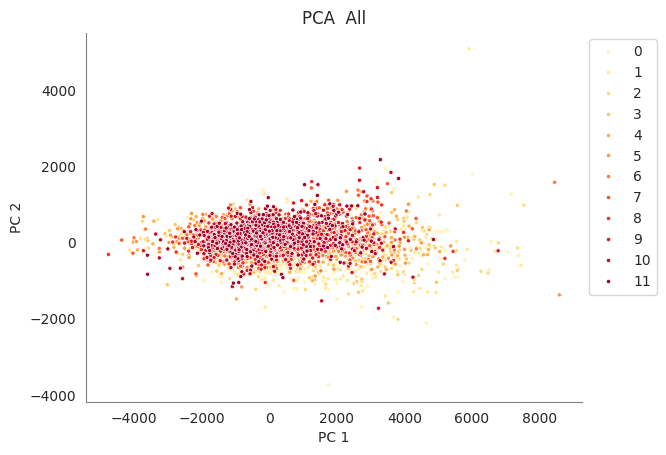

In [140]:
_, result = makePCA(df1,cmap)

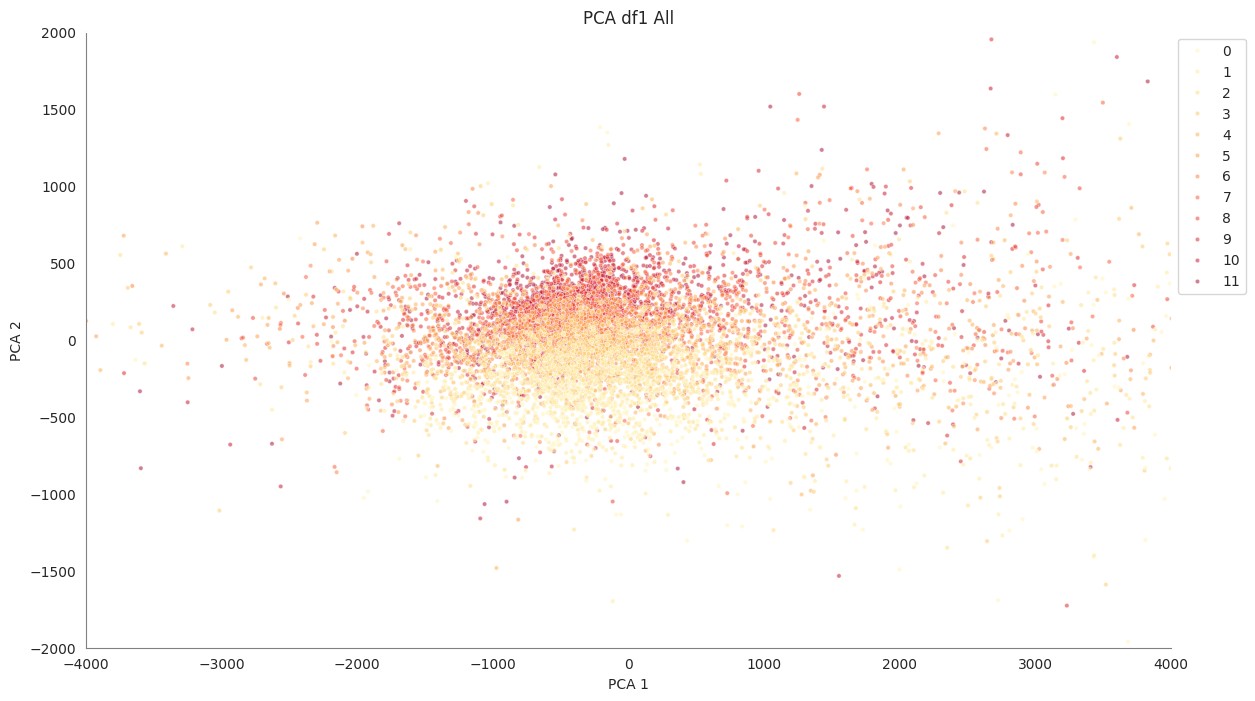

In [141]:
name = 'df1'
# Invert the order of results
results = result
results = results[::-1]
hue = results['Metadata_Site'].to_list()

fig = plt.figure(
figsize=[14, 8]
)
ax = fig.add_subplot(111)
ax.set_xlabel('PCA 1', fontsize = 10)
ax.set_ylabel('PCA 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x=results['pc1'].to_list(),
                y=results['pc2'].to_list(),
                palette=cmap,
                hue=hue,
                marker='.',
                s=40, 
                alpha=0.5,
                ).set(title=f'PCA {name} All'
            )
ax.set_facecolor('w')
ax.get_legend().remove()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(-2000, 2000)
ax.set_xlim(-4000, 4000)
# if not os.path.exists(f'{OutputDir}/{statmet}'):
#     os.makedirs(f'{OutputDir}/{statmet}')
# plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')

# fig.savefig(
#         "2_PCAUMAP/result-images/UMAP_pathway_{}_{}.{}".format(cell_line, data_type,figformat), dpi=dpi, bbox_inches="tight"
#         )

plt.show()
plt.close()

In [135]:
filename2 = filenames[1]
# df = pl.read_parquet(f'{feat_pp}/{filename}.parquet')
df2 = readData(filename2, feat_dir=feat_pp, filetype='parquet')
cmap = sns.color_palette("YlOrRd", n_colors=len(df2['Metadata_Site'].unique().to_list()))

/tmp/ipykernel_658539/2733699382.py:18: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_onehot'))
/tmp/ipykernel_658539/2733699382.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


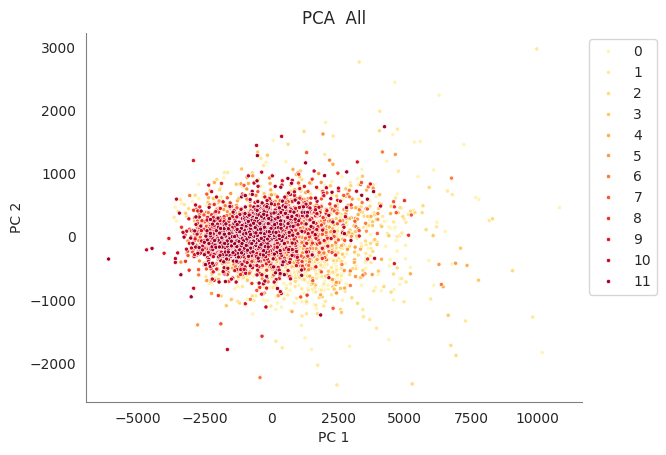

In [136]:
_,result = makePCA(df2,cmap)

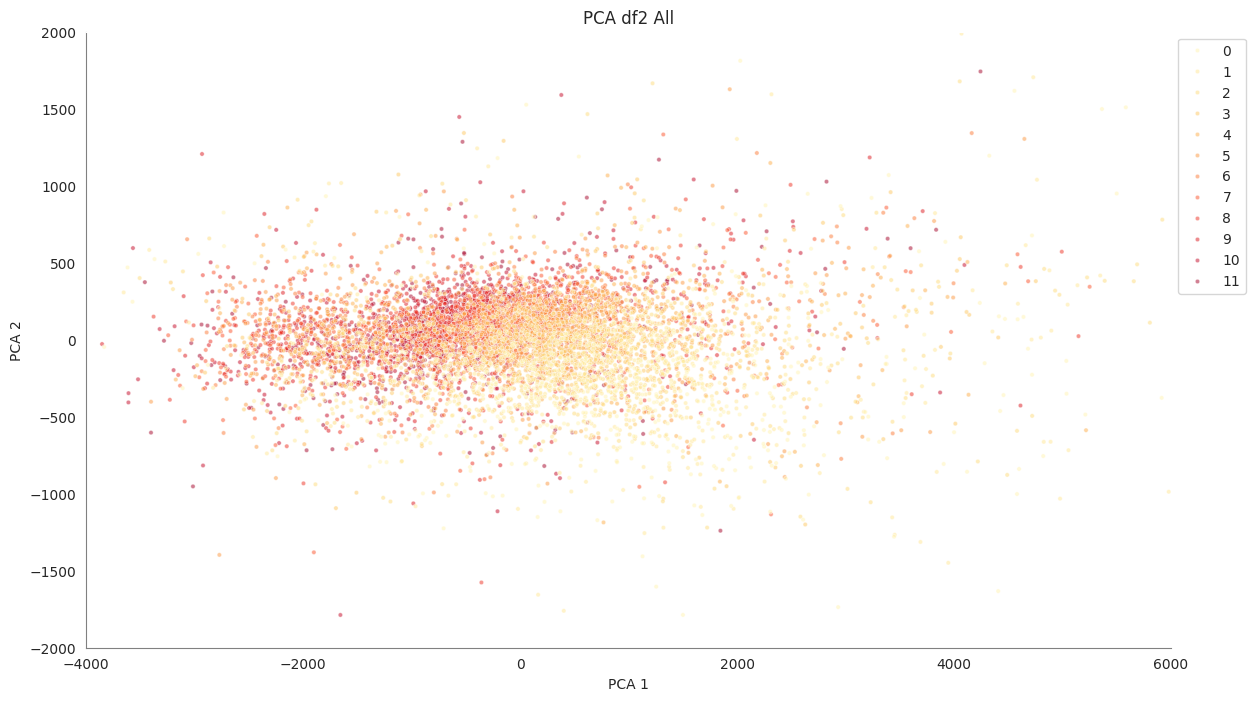

In [139]:
name = 'df2'
# Invert the order of results
results = result
results = results[::-1]
hue = results['Metadata_Site'].to_list()

fig = plt.figure(
figsize=[14, 8]
)
ax = fig.add_subplot(111)
ax.set_xlabel('PCA 1', fontsize = 10)
ax.set_ylabel('PCA 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x=results['pc1'].to_list(),
                y=results['pc2'].to_list(),
                palette=cmap,
                hue=hue,
                marker='.',
                s=40, 
                alpha=0.5,
                ).set(title=f'PCA {name} All'
            )
ax.set_facecolor('w')
ax.get_legend().remove()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(-2000, 2000)
ax.set_xlim(-4000, 6000)
# if not os.path.exists(f'{OutputDir}/{statmet}'):
#     os.makedirs(f'{OutputDir}/{statmet}')
# plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')

# fig.savefig(
#         "2_PCAUMAP/result-images/UMAP_pathway_{}_{}.{}".format(cell_line, data_type,figformat), dpi=dpi, bbox_inches="tight"
#         )

plt.show()
plt.close()

In [129]:
filename3 = filenames[0]
print(filename3+'/'+feat_fe)
# df = pl.read_parquet(f'{feat_pp}/{filename}.parquet')
df3 = readData(filename3, feat_dir=feat_fe, filetype='parquet')
cmap = sns.color_palette("YlOrRd", n_colors=len(df3['Metadata_Site'].unique().to_list()))

SingleSlice/HCT116_Slices_medianAgg/1_FeaturesImages_meanstd


/tmp/ipykernel_658539/2733699382.py:18: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_onehot'))
/tmp/ipykernel_658539/2733699382.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


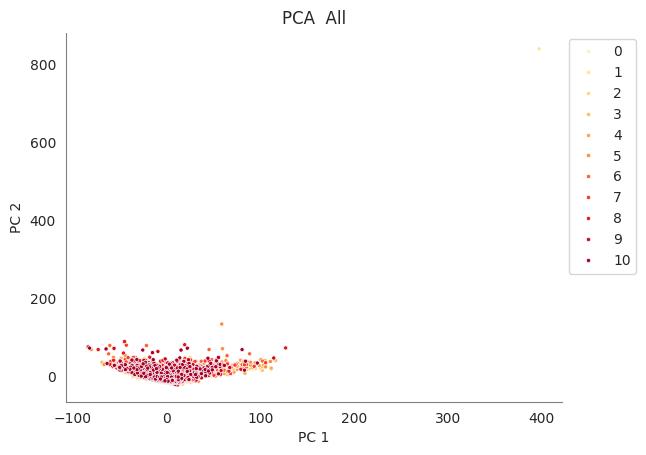

In [117]:
_,result = makePCA(df3,cmap)

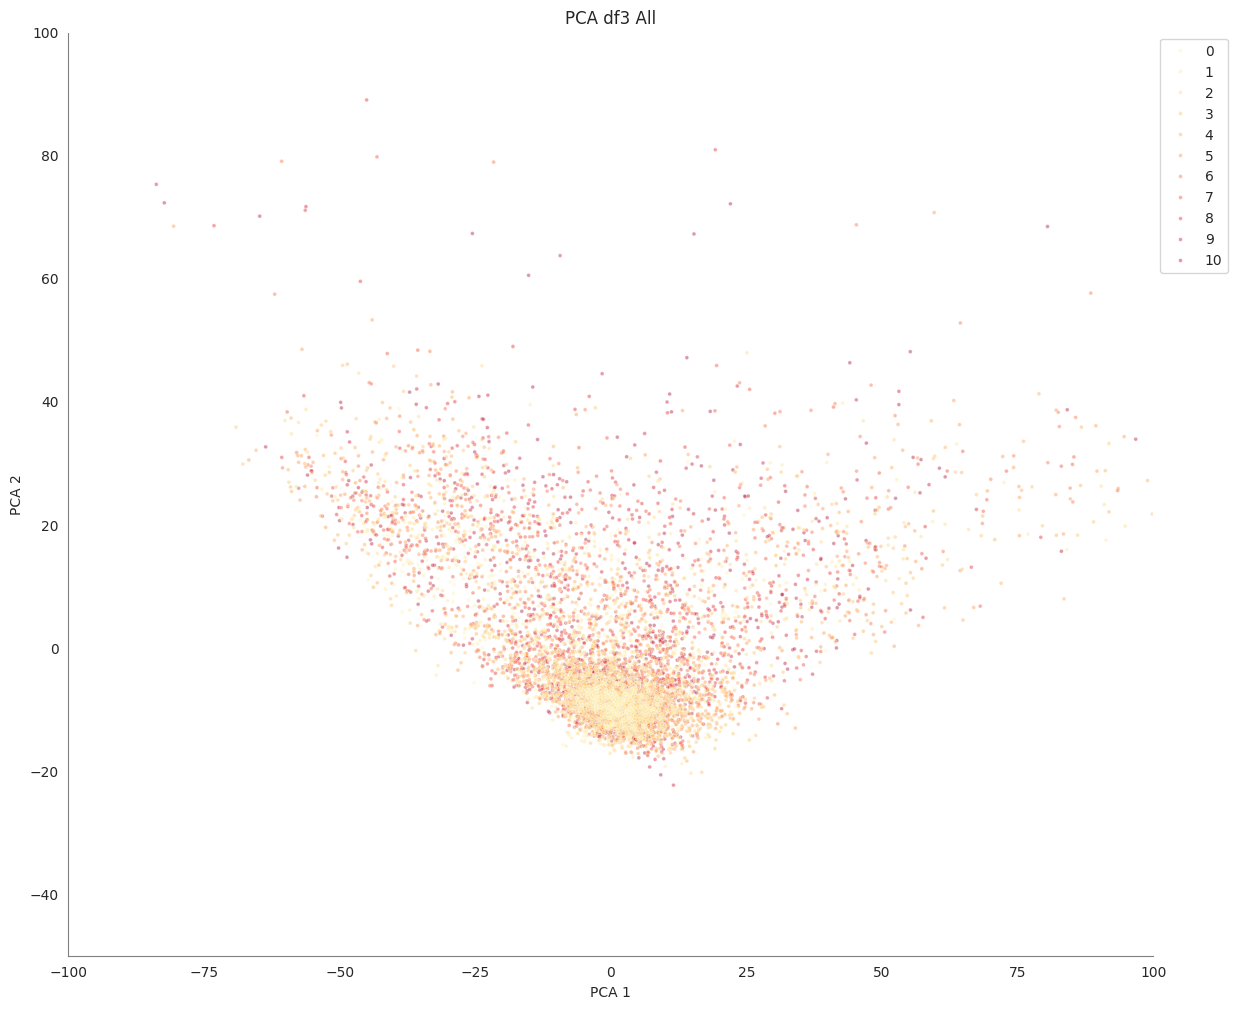

In [126]:
name = 'df3'
# Invert the order of results
results = result
results = results[::-1]
hue = results['Metadata_Site'].to_list()

fig = plt.figure(
figsize=[14, 12]
)
ax = fig.add_subplot(111)
ax.set_xlabel('PCA 1', fontsize = 10)
ax.set_ylabel('PCA 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x=results['pc1'].to_list(),
                y=results['pc2'].to_list(),
                palette=cmap,
                hue=hue,
                marker='.',
                s=30, 
                alpha=0.4,
                ).set(title=f'PCA {name} All'
            )
ax.set_facecolor('w')
ax.get_legend().remove()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(-50, 100)
ax.set_xlim(-100, 100)
# if not os.path.exists(f'{OutputDir}/{statmet}'):
#     os.makedirs(f'{OutputDir}/{statmet}')
# plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')

# fig.savefig(
#         "2_PCAUMAP/result-images/UMAP_pathway_{}_{}.{}".format(cell_line, data_type,figformat), dpi=dpi, bbox_inches="tight"
#         )

plt.show()
plt.close()

In [130]:
filename4 = filenames[1]
# df = pl.read_parquet(f'{feat_pp}/{filename}.parquet')
df4 = readData(filename4, feat_dir=feat_fe, filetype='parquet')
cmap = sns.color_palette("YlOrRd", n_colors=len(df4['Metadata_Site'].unique().to_list()))

/tmp/ipykernel_658539/2733699382.py:18: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_onehot'))
/tmp/ipykernel_658539/2733699382.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


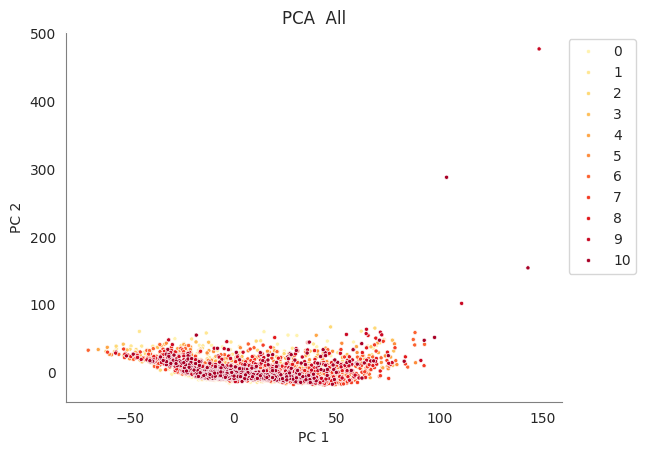

In [131]:
_,result = makePCA(df4,cmap)

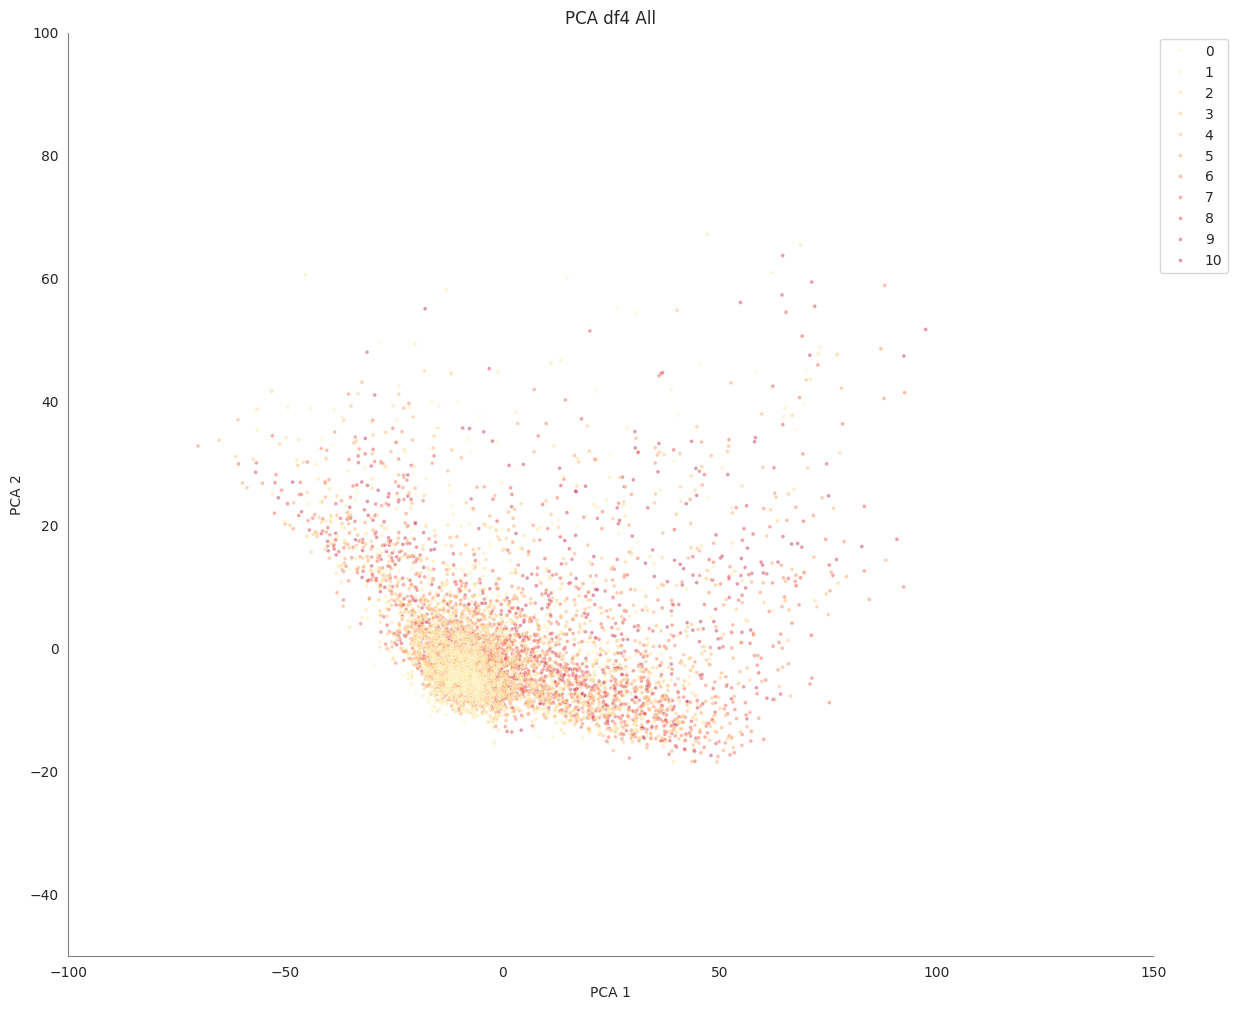

In [133]:
name = 'df4'
# Invert the order of results
results = result
results = results[::-1]
hue = results['Metadata_Site'].to_list()

fig = plt.figure(
figsize=[14, 12]
)
ax = fig.add_subplot(111)
ax.set_xlabel('PCA 1', fontsize = 10)
ax.set_ylabel('PCA 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x=results['pc1'].to_list(),
                y=results['pc2'].to_list(),
                palette=cmap,
                hue=hue,
                marker='.',
                s=30, 
                alpha=0.4,
                ).set(title=f'PCA {name} All'
            )
ax.set_facecolor('w')
ax.get_legend().remove()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(-20, 100)
ax.set_xlim(-100, 150)
# if not os.path.exists(f'{OutputDir}/{statmet}'):
#     os.makedirs(f'{OutputDir}/{statmet}')
# plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')

# fig.savefig(
#         "2_PCAUMAP/result-images/UMAP_pathway_{}_{}.{}".format(cell_line, data_type,figformat), dpi=dpi, bbox_inches="tight"
#         )

plt.show()
plt.close()